In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

from qiskit import execute, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, IBMQ

from qiskit.visualization import plot_histogram

In [2]:
def example_grover_iteration():
    qc = QuantumCircuit(4)
    qc.h([2, 3])
    qc.ccx(0, 1, 2)
    qc.h(2)
    qc.x(2)
    qc.ccx(0, 2, 3)
    qc.x(2)
    qc.h(3)
    qc.x([1,3])
    qc.h(2)
    qc.mct([0,1,3],2)
    qc.x([1,3])
    qc.h(2)
    qc.h(range(3))
    qc.x(range(3))
    qc.z(3)
    qc.mct([0,1,2],3)
    qc.x(range(3))
    qc.h(range(3))
    qc.z(3)
    return qc

In [4]:
grit = example_grover_iteration().to_gate()

In [6]:
cgrit = grit.control()

In [7]:
cgrit.label = 'Grover'

In [9]:
def qft(n):
    circuit = QuantumCircuit(4)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cu1(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [10]:
qft_dagger = qft(4).to_gate().inverse()
qft_dagger.label = 'QFT†'

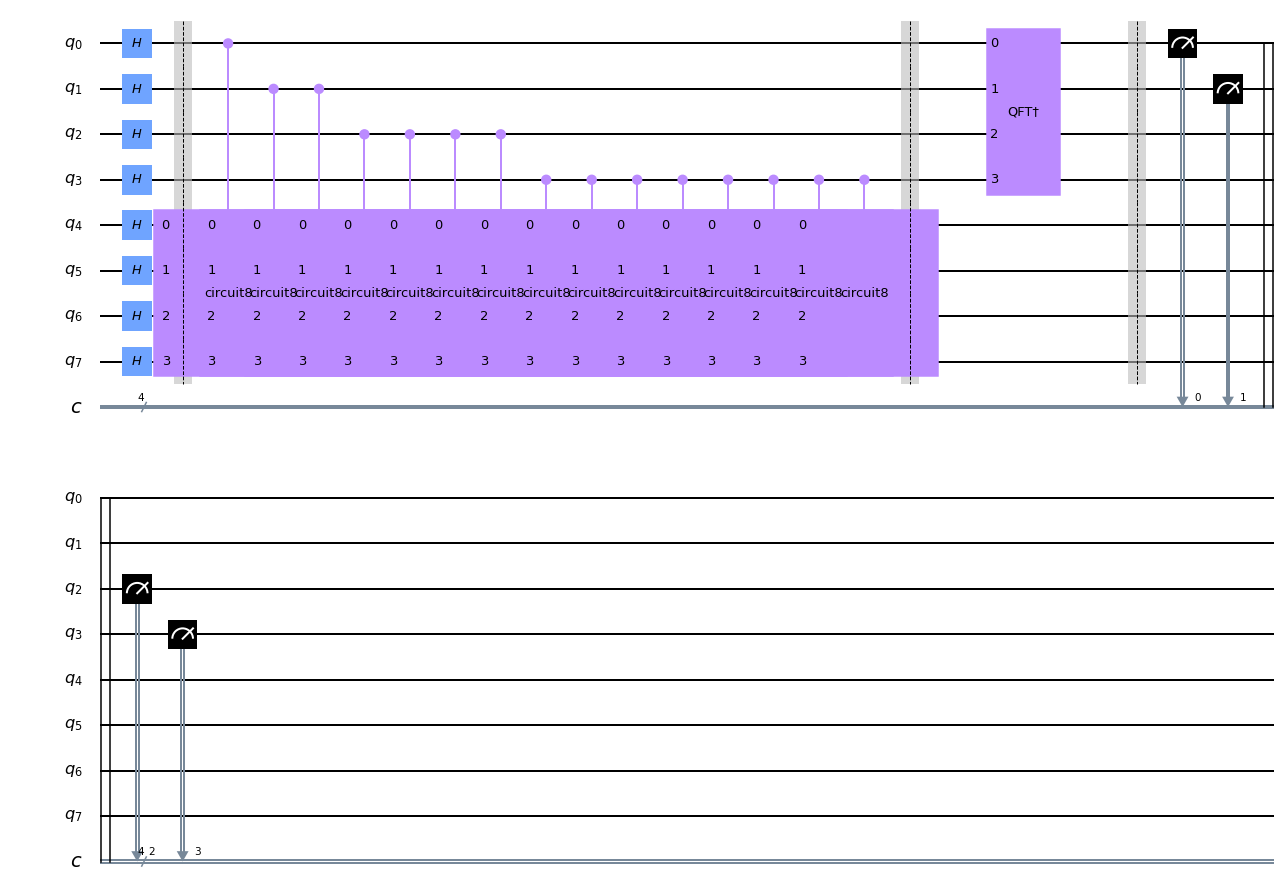

In [11]:
t = 4
n = 4
qc = QuantumCircuit(n+t, t)
qc.h(range(n+t))

qc.barrier()
iterations = 1
for qubit in range(t):
    for i in range(iterations):
        qc.append(cgrit, [qubit] + [*range(t, n+t)])
    iterations *= 2
    
qc.barrier()
qc.append(qft_dagger, range(t))

qc.barrier()
qc.measure(range(t), range(t))

qc.draw('mpl')

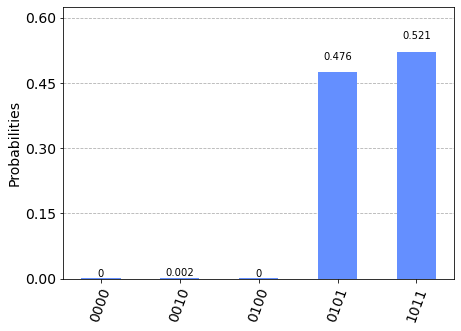

In [12]:
backend = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend).result().get_counts()
plot_histogram(counts)

In [13]:
measured_str = max(counts, key=counts.get)

In [14]:
measured_str

'1011'

In [15]:
value = int(measured_str, 2)

In [16]:
value

11

In [18]:
theta = (value/(2**t))*math.pi*2
print("Theta = %.5f" % theta)

Theta = 4.31969


In [19]:
N = 2**n
M = N * (math.sin(theta/2)**2)
print("No. of Solutions = %.1f" % (N-M))

No. of Solutions = 4.9
